In [1]:
# !pip install nibabel
# !pip PIL
# !pip install numpy

In [2]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize

# Data source

- put the raw file path
- prefered directory to store the processed data

In [3]:
raw_data_path = "Oluvil.rar"
target_data_path = "target"

# Connect to the google drive

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Changing the directory
%cd '/content/drive/MyDrive/test/oluvil/updated data'

/content/drive/MyDrive/test/oluvil/updated data


In [6]:
import os

# Path to the .rar file
raw_data_path = "Oluvil.rar"

# Specify the target directory where you want to extract the files
source_dir = os.path.join("target", "dataset")

# Ensure the target directory exists
os.makedirs(source_dir, exist_ok=True)

# Unrar the file into the target directory
!unrar x -v '{raw_data_path}' '{source_dir}/'



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Oluvil.rar


Would you like to replace the existing file target/dataset/Oluvil/EPR/sentinel2_void_2019-01-28_Oluvil.png
 15308 bytes, modified on 2025-01-30 17:32
with a new one
 15308 bytes, modified on 2025-01-30 17:32

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


# Partition the data

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
image_dir = os.path.join(target_data_path, "dataset/Oluvil/satellite")  # Satellite images
mask_dir = os.path.join(target_data_path, "dataset/Oluvil/EPR")  # Binary EPR masks

train_dir = os.path.join(target_data_path, "training")
val_dir = os.path.join(target_data_path, "validation")
test_dir = os.path.join(target_data_path, "testing")


# Create directories for training, validation, and testing sets
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "masks"), exist_ok=True)

# Get all image filenames (ignoring path)
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Ensure masks exist for each image (based on base name, with .png extension)
valid_images = [
    f for f in image_filenames
    if os.path.exists(os.path.join(mask_dir, os.path.splitext(f)[0] + '.png'))
]

print(f"Total valid image-mask pairs found: {len(valid_images)}")

# Split dataset (70% train, 15% val, 15% test)
train_files, test_files = train_test_split(valid_images, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.50, random_state=42)  # 15% each

# Function to move files
def move_files(file_list, src_img, src_mask, dest):
    for f in file_list:
        mask_filename = os.path.splitext(f)[0] + '.png'  # Construct corresponding mask filename
        shutil.copy(os.path.join(src_img, f), os.path.join(dest, "images", f))
        shutil.copy(os.path.join(src_mask, mask_filename), os.path.join(dest, "masks", mask_filename))

# Move files to respective folders
move_files(train_files, image_dir, mask_dir, train_dir)
move_files(val_files, image_dir, mask_dir, val_dir)
move_files(test_files, image_dir, mask_dir, test_dir)

print("Dataset successfully split into Training, Validation, and Testing sets!")


Total valid image-mask pairs found: 69
Dataset successfully split into Training, Validation, and Testing sets!


# Visualize raw data

In [8]:
# Plot image and its corresponding segmentation mask
def plot_images(img, mask):
    if img is None or mask is None:
        print("Error: One or both files could not be loaded.")
        return

    print("img shape:", img.shape)
    print("mask shape:", mask.shape)
    print("mask min:", mask.min())
    print("mask max:", mask.max())
    print("mask unique values:", np.unique(mask))

    viz_dict = {"Image": img, "Segmentation Map": mask}

    fig = plt.figure(figsize=(15, 15))

    count = 2
    for i, j in viz_dict.items():
        ax = plt.subplot(1, 3, count)
        plt.imshow(j, cmap='gray')
        plt.title(i)
        plt.axis("on")
        count += 1


def plot_images_by_path(image_path, mask_path):
    # Check if files exist
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found at {mask_path}")
        return

    img = cv2.imread(image_path)  # Load the image in color (BGR format)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask in grayscale (binary)

    plot_images(img, mask)


def plot_images_after_cleaning(img,mask):

  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}
  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.colorbar()
    plt.title(i)
    plt.axis("on")
    count += 1


img shape: (1741, 1146, 3)
mask shape: (1741, 1146)
mask min: 0
mask max: 255
mask unique values: [  0 255]


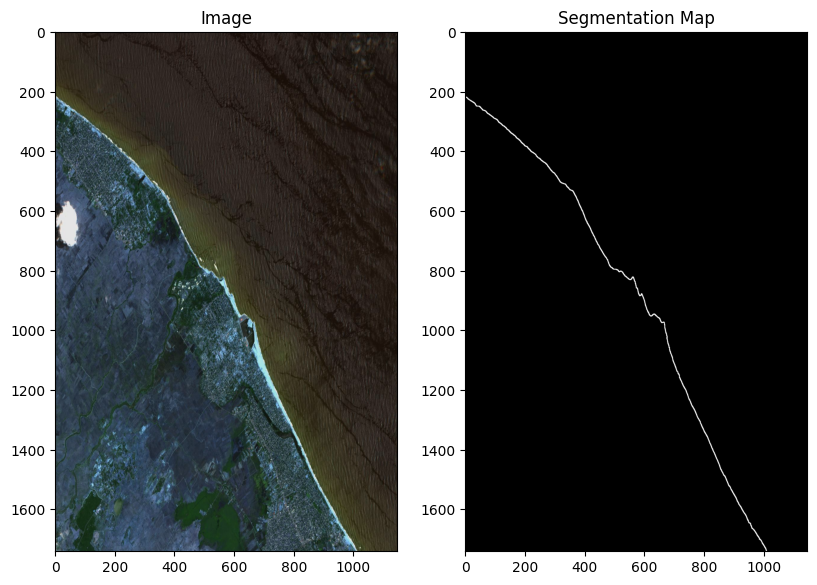

In [9]:
image_path = 'target/training/images/sentinel2_void_2022-10-09_Oluvil.jpg'
mask_path =  'target/training/masks/sentinel2_void_2022-10-09_Oluvil.png'

plot_images_by_path(image_path, mask_path)

# Slect and load the data

In [10]:
# Function to select image and mask files
def select_data(env, datatype_annotation):
    file_input = f'target/{env}/*/*{datatype_annotation}*'
    return sorted(glob.glob(file_input))

# Function to load images and masks
def load_data(image_filenames, mask_filenames):
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames):
        img = cv2.imread(file_name)  # Read image in color (BGR)
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        masks.append(mask)

    return images, masks


In [11]:
import cv2
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

# Function to select image and mask files
def select_data(env, datatype_annotation):
    file_input = f'target/{env}/*/*{datatype_annotation}*'
    return sorted(glob.glob(file_input))

# Function to crop image to a square from the center
def crop_to_square(image):
    height, width = image.shape[:2]  # Get image dimensions
    min_dim = min(height, width)  # Find the shortest side

    # Calculate center crop box
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    return image[top:bottom, left:right]  # Crop and return

# Function to load images and masks with cropping & resizing
def load_data(image_filenames, mask_filenames):
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames):
        img = cv2.imread(file_name)  # Read image in color (BGR)
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = crop_to_square(img)
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        mask = crop_to_square(mask)
        masks.append(mask)

    return images, masks

## Training

In [12]:
# Select files for training images and masks
training_image_files = select_data('training', '.jpg')
training_mask_files = select_data('training', '.png')

# Load training images and masks
training_images, training_masks = load_data(training_image_files, training_mask_files)

# Print sample information
print(f"\n \nTraining images: {len(training_images)}")
print(f"Training masks: {len(training_masks)}")

100%|██████████| 48/48 [00:00<00:00, 49.48it/s]


 
Training images: 48
Training masks: 48


## Testing

In [13]:
# Select files for training images and masks
testing_image_files = select_data('testing', '.jpg')
testing_mask_files = select_data('testing', '.png')

# Load testing images and masks
testing_images, testing_masks = load_data(testing_image_files, testing_mask_files)

# Print sample information
print(f"testing images: {len(testing_images)}")
print(f"testing masks: {len(testing_masks)}")

100%|██████████| 11/11 [00:00<00:00, 50.84it/s]

testing images: 11
testing masks: 11


## Validation

In [14]:

# Select files for validation images and masks
validation_image_files = select_data('validation', '.jpg')
validation_mask_files = select_data('validation', '.png')

# Load validation images and masks
validation_images, validation_masks = load_data(validation_image_files, validation_mask_files)

# Print sample information
print(f"validation images: {len(validation_images)}")
print(f"validation masks: {len(validation_masks)}")

100%|██████████| 10/10 [00:00<00:00, 48.52it/s]

validation images: 10
validation masks: 10


# Formating

- resizing the image

In [15]:
from skimage.transform import resize

def resize_images(images_raw, masks_raw,target_size=(512, 512)):
  images = []
  masks = []

  for img, msk in zip(images_raw, masks_raw):
    # Resize to 200x200
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)  # Resize to target size
    msk = cv2.resize(msk, target_size, interpolation=cv2.INTER_NEAREST)  # Resize masks using NEAREST interpolation

    images.append(img)
    masks.append(msk)


  return images, masks;

In [16]:
# Trainning data resize
training_images, training_masks = resize_images(training_images, training_masks)

# Testing data resize
testing_images, testing_masks = resize_images(testing_images, testing_masks)

# Validation data resize
validation_images, validation_masks = resize_images(validation_images, validation_masks)

In [17]:
print(f"Validation images count: {len(validation_images)}")
print(f"Validation masks count: {len(validation_masks)}")


Validation images count: 10
Validation masks count: 10


img  (512, 512, 3)
mask  (512, 512)
mask min  0
mask max  255
mask unique values  [  0 255]


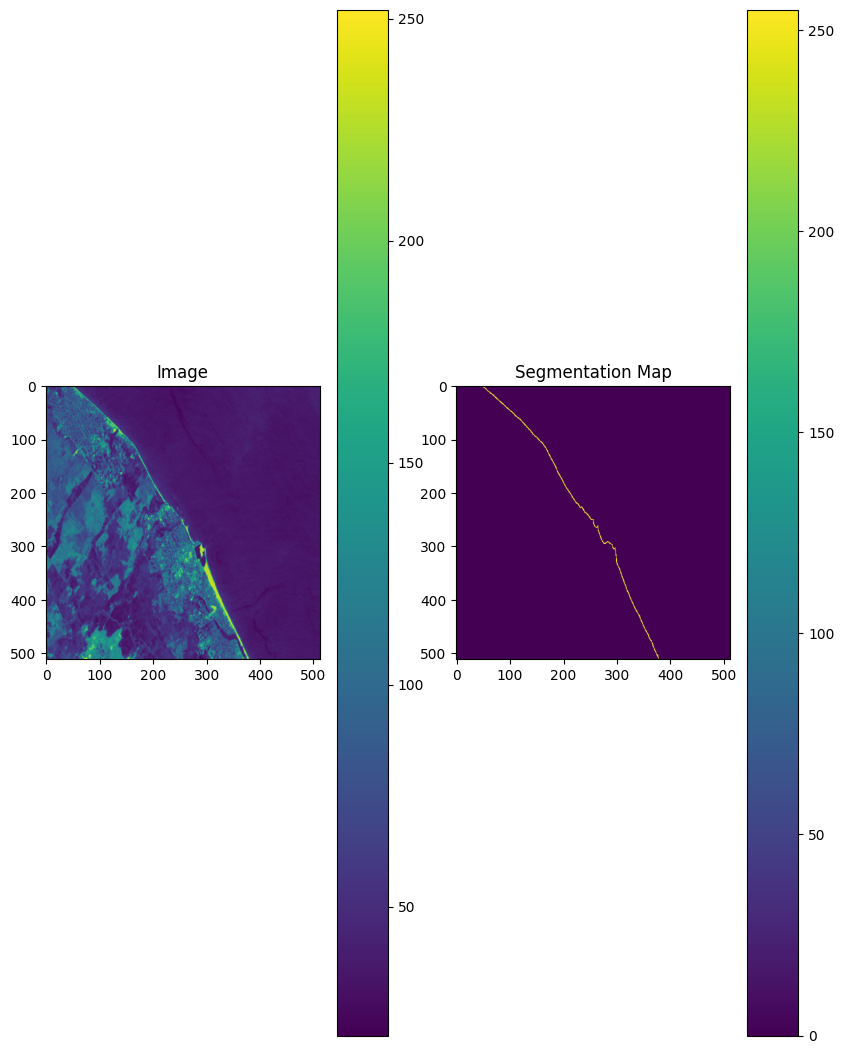

In [18]:
plot_images_after_cleaning(validation_images[0], validation_masks[0])

In [19]:
!mkdir -p 'target/training/numpy'
!mkdir -p 'target/testing/numpy'
!mkdir -p 'target/validation/numpy'

In [20]:
np.save('target/training/numpy/images.npy', training_images)
np.save('target/training/numpy/masks.npy', training_masks)

In [21]:
np.save('target/testing/numpy/images.npy', testing_images)
np.save('target/testing/numpy/masks.npy', testing_masks)

In [22]:
np.save('target/validation/numpy/images.npy', validation_images)
np.save('target/validation/numpy/masks.npy', validation_masks)

img shape: (512, 512, 3)
mask shape: (512, 512)
mask min: 0
mask max: 255
mask unique values: [  0 255]


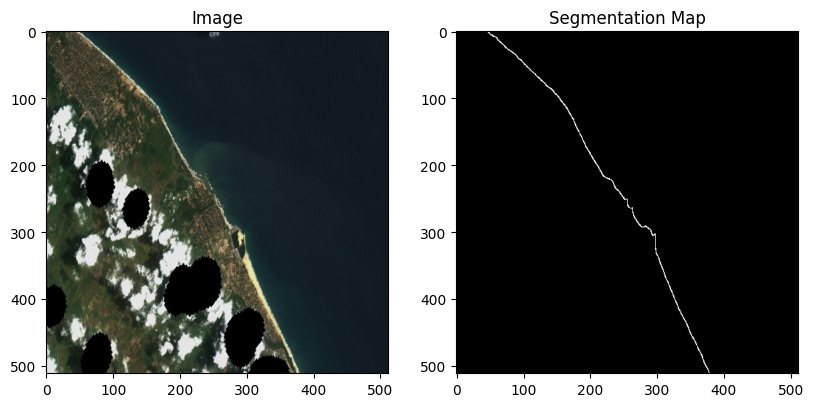

In [23]:
plot_images(training_images[0],training_masks[0])